In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = 0.8

In [3]:
from nltk.corpus import stopwords

In [4]:
df = pd.read_csv('transcription_fresh.csv', usecols=['medical_specialty', 'transcription'])

In [5]:
df.head()

,medical_specialty,transcription
0,Orthopedic,"TITLE OF OPERATION: , Youngswick osteotomy wit..."
1,Orthopedic,"PREOPERATIVE DIAGNOSES:,1. Hallux rigidus, le..."
2,Orthopedic,"CHIEF COMPLAINT:, Left wrist pain.,HISTORY OF..."
3,Orthopedic,"PREOPERATIVE DIAGNOSIS: , Wrist ganglion.,POST..."
4,Orthopedic,"PREOPERATIVE DIAGNOSIS:, T11 compression frac..."


In [6]:
df = df.dropna(axis=0, subset=['transcription'])

In [7]:
df.medical_specialty.value_counts()

 Surgery                       664
 Consult - History and Phy.    465
 Cardiovascular / Pulmonary    318
 Orthopedic                    316
Name: medical_specialty, dtype: int64

In [8]:
######### balancing dataset
balance_point = 316
def balance_dataset(df):
    df1 = df[df.medical_specialty == ' Consult - History and Phy.'].iloc[:balance_point]
    df2 = df[df.medical_specialty == ' Cardiovascular / Pulmonary'].iloc[:balance_point]
    df3 = df[df.medical_specialty == ' Orthopedic'].iloc[:balance_point]
    df4 = df[df.medical_specialty == ' Surgery'].iloc[:balance_point]
    
    frames = [df1, df2, df3, df4]
    return pd.concat(frames)

df = balance_dataset(df)

In [9]:
### shuffling the dataset
from sklearn.utils import shuffle
df = shuffle(df)

In [10]:
df

,medical_specialty,transcription
420,Surgery,"DIAGNOSIS:, Stasis ulcers of the lower extrem..."
1495,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, Patient is a 50-..."
1477,Consult - History and Phy.,"CC:, Stable expressive aphasia and decreased v..."
1577,Consult - History and Phy.,"CHIEF COMPLAINT:, Jaw pain this morning.,BRIE..."
582,Surgery,"OPERATIVE NOTE: ,The patient was taken to the..."
...,...,...
81,Orthopedic,"ADMISSION DIAGNOSIS: , Right tibial plateau fr..."
1529,Consult - History and Phy.,"CC:, Slowing of motor skills and cognitive fun..."
1057,Cardiovascular / Pulmonary,"NUCLEAR CARDIOLOGY/CARDIAC STRESS REPORT,INDIC..."
1096,Cardiovascular / Pulmonary,"INDICATIONS: , Predominant rhythm is sinus. H..."


In [11]:
df = df.reset_index(drop=True)

In [12]:
#### encoding the class
df['medical_specialty'] = df['medical_specialty'].astype('category')
df["medical_specialty_cat"] = df["medical_specialty"].cat.codes

In [13]:
messages = df.transcription.tolist()
labels = df['medical_specialty_cat']

In [14]:
########## finding map class to integer value #############
class0 = df[df.medical_specialty_cat == 0].iloc[0].medical_specialty
class1 = df[df.medical_specialty_cat == 1].iloc[0].medical_specialty
class2 = df[df.medical_specialty_cat == 2].iloc[0].medical_specialty
class3 = df[df.medical_specialty_cat == 3].iloc[0].medical_specialty
classes = {0 : class0, 1 : class1, 2 : class2, 3 : class3}

In [15]:
print(classes)

{0: ' Cardiovascular / Pulmonary', 1: ' Consult - History and Phy.', 2: ' Orthopedic', 3: ' Surgery'}


In [16]:
df

,medical_specialty,transcription,medical_specialty_cat
0,Surgery,"DIAGNOSIS:, Stasis ulcers of the lower extrem...",3
1,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, Patient is a 50-...",1
2,Consult - History and Phy.,"CC:, Stable expressive aphasia and decreased v...",1
3,Consult - History and Phy.,"CHIEF COMPLAINT:, Jaw pain this morning.,BRIE...",1
4,Surgery,"OPERATIVE NOTE: ,The patient was taken to the...",3
...,...,...,...
1259,Orthopedic,"ADMISSION DIAGNOSIS: , Right tibial plateau fr...",2
1260,Consult - History and Phy.,"CC:, Slowing of motor skills and cognitive fun...",1
1261,Cardiovascular / Pulmonary,"NUCLEAR CARDIOLOGY/CARDIAC STRESS REPORT,INDIC...",0
1262,Cardiovascular / Pulmonary,"INDICATIONS: , Predominant rhythm is sinus. H...",0


In [17]:
messages

['DIAGNOSIS:,  Stasis ulcers of the lower extremities,OPERATION:,  Split-thickness skin grafting a total area of approximately 15 x 18 cm on the right leg and 15 x 15 cm on the left leg.,INDICATIONS:,  This 84-year old female presented recently with large ulcers of the lower extremities.  These were representing on the order of 50% or more of the circumference of her lower leg.  They were in a distribution to be consistent with stasis ulcers.  They were granulating nicely and she was scheduled for surgery.,FINDINGS:,  Large ulcers of lower extremities with size as described above.  These are irregular in shape and posterior and laterally on the lower legs.  There was no evidence of infection.  The ultimate skin grafting was quite satisfactory.,PROCEDURE: , Having obtained adequate general endotracheal anesthesia, the patient was prepped from the pubis to the toes.  The legs were examined and the wounds were Pulsavaced bilaterally with 3 liters of saline with Bacitracin.  The wounds wer

In [18]:
#Data cleaning and preprocessing
import re
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
sentences = []

for i in range(0, len(messages)):
    message = re.sub('[^a-zA-Z]', ' ', str(messages[i]))
    message = message.lower()
    message = message.split()
    
    message = [lemmatizer.lemmatize(word) for word in message if not word in stopwords.words('english')]
    message = ' '.join(message)
    sentences.append(message)

In [19]:
##### spliting the dataset into train and validation set
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]


In [20]:
################augmenting training data #########################
def augment(train_sentences, train_labels):
    aug_syn = naw.SynonymAug(aug_src='wordnet')
    # augmented_text = aug_syn.augment(text)
    augmented_texts = []
    labels = []
    for i in range(len(train_sentences)):
        text = train_sentences[i]
        print(i)
        label = train_labels[i]
        for j in range(10):
            augmented_text = aug_syn.augment(text)
            augmented_texts.append(augmented_text)
            labels.append(label)


    return augmented_texts, pd.Series(labels)

#train_sentences, train_labels = augment(train_sentences, train_labels)

In [21]:
#### deep learning tokenizer technique is used to tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, truncating = trunc_type, maxlen=max_length)


In [22]:
train_padded[0]

array([  15, 6380, 1270,   75,   42,  252, 1441, 1496,   25, 1870,  207,
         34,   77,   20,   84,    3,  232,   20,   84,    4,  232,  181,
         16,   33,  187,  530,  604,  194, 1270,   75,   42, 6381,  701,
       2920,   75,  232, 1442,  454, 6380, 1270, 9333, 2573, 1317,   64,
         99,  194, 1270,   75,   42,  204,  681, 1701, 1913,   52,  417,
         75,  232,  112,  267, 9334,   25, 1870,  596,  392,    6,   69,
        255,   32,  256,   21,    2,   85, 3558,  478,  232, 1087,   89,
       9335,  118, 1443,  331, 1598,   89,  780,  255,  168,  268, 4011,
       1444,  637,   23, 1520,   25, 2676,    3,  741,   77,  625, 9336,
       3384,   40,   89,   89, 1072, 1240, 3218, 1702, 3384,   40,    9,
       1562, 1599, 9337,  393, 1072,  425, 1562,  244, 1914, 1445],
      dtype=int32)

In [23]:
train_sequences[0]

[15,
 6380,
 1270,
 75,
 42,
 252,
 1441,
 1496,
 25,
 1870,
 207,
 34,
 77,
 20,
 84,
 3,
 232,
 20,
 84,
 4,
 232,
 181,
 16,
 33,
 187,
 530,
 604,
 194,
 1270,
 75,
 42,
 6381,
 701,
 2920,
 75,
 232,
 1442,
 454,
 6380,
 1270,
 9333,
 2573,
 1317,
 64,
 99,
 194,
 1270,
 75,
 42,
 204,
 681,
 1701,
 1913,
 52,
 417,
 75,
 232,
 112,
 267,
 9334,
 25,
 1870,
 596,
 392,
 6,
 69,
 255,
 32,
 256,
 21,
 2,
 85,
 3558,
 478,
 232,
 1087,
 89,
 9335,
 118,
 1443,
 331,
 1598,
 89,
 780,
 255,
 168,
 268,
 4011,
 1444,
 637,
 23,
 1520,
 25,
 2676,
 3,
 741,
 77,
 625,
 9336,
 3384,
 40,
 89,
 89,
 1072,
 1240,
 3218,
 1702,
 3384,
 40,
 9,
 1562,
 1599,
 9337,
 393,
 1072,
 425,
 1562,
 244,
 1914,
 1445,
 2396,
 7452,
 45,
 5636,
 139,
 940,
 3219,
 13,
 790,
 44,
 463,
 1667,
 4704,
 153,
 1072,
 3220,
 153,
 2,
 165,
 6,
 9,
 605,
 182,
 30,
 392,
 71]

In [24]:
train_padded.shape

(1011, 120)

In [25]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type,truncating = trunc_type, maxlen=max_length)

In [26]:
validation_labels.value_counts()

3    65
1    65
2    62
0    61
Name: medical_specialty_cat, dtype: int64

In [27]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.regularizers import l1

In [28]:
## Creating model
lstm_model=Sequential()
lstm_model.add(Embedding(vocab_size,embedding_dim,input_length = max_length))
lstm_model.add(Bidirectional(LSTM(100, activity_regularizer=l1(0.001))))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(4,activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               93600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 254,404
Trainable params: 254,404
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(train_padded.shape)
print(train_labels.shape)
print(validation_padded.shape)
print(validation_labels.shape)

(1011, 120)
(1011,)
(253, 120)
(253,)


In [30]:
num_epochs = 30
history = lstm_model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/30
32/32 - 8s - loss: 1.3386 - accuracy: 0.3571 - val_loss: 1.1696 - val_accuracy: 0.5494
Epoch 2/30
32/32 - 7s - loss: 1.0066 - accuracy: 0.5628 - val_loss: 0.9584 - val_accuracy: 0.5731
Epoch 3/30
32/32 - 7s - loss: 0.7266 - accuracy: 0.6914 - val_loss: 0.8433 - val_accuracy: 0.6759
Epoch 4/30
32/32 - 7s - loss: 0.6416 - accuracy: 0.7369 - val_loss: 0.8730 - val_accuracy: 0.7194
Epoch 5/30
32/32 - 7s - loss: 0.5235 - accuracy: 0.7844 - val_loss: 0.8095 - val_accuracy: 0.6957
Epoch 6/30
32/32 - 7s - loss: 0.4407 - accuracy: 0.8417 - val_loss: 0.5298 - val_accuracy: 0.8340
Epoch 7/30
32/32 - 7s - loss: 0.2975 - accuracy: 0.9149 - val_loss: 0.5940 - val_accuracy: 0.8261
Epoch 8/30
32/32 - 7s - loss: 0.2268 - accuracy: 0.9337 - val_loss: 0.6261 - val_accuracy: 0.7470
Epoch 9/30
32/32 - 7s - loss: 0.1576 - accuracy: 0.9614 - val_loss: 0.5486 - val_accuracy: 0.8498
Epoch 10/30
32/32 - 8s - loss: 0.1747 - accuracy: 0.9644 - val_loss: 0.6142 - val_accuracy: 0.8261
Epoch 11/30
32/32 -

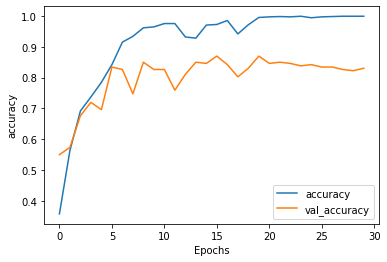

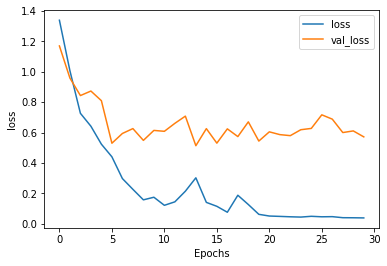

In [31]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [32]:
########## Attention based lstm

In [33]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.regularizers import l1

In [34]:
def RNN():
    inputs = Input(name='inputs',shape=[max_length])
    layer = Embedding(vocab_size,embedding_dim,input_length=max_length)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(4,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [35]:
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    # output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [36]:
def model_attention_applied_after_lstm():
    #inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    inputs = Input(name='inputs',shape=[max_length])
    layer = Embedding(vocab_size,embedding_dim,input_length=max_length)(inputs)
    
    lstm_units = 64
    lstm_out = LSTM(lstm_units, return_sequences=True)(layer)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='softmax')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [37]:
from keras.layers import merge
from keras.layers import multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

from keras.utils.vis_utils import plot_model

In [38]:
# INPUT_DIM = 50
TIME_STEPS = max_length

In [39]:
attention_lstm_model = model_attention_applied_after_lstm()

In [40]:
attention_lstm_model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
attention_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 120, 16)      160000      inputs[0][0]                     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 120, 64)      20736       embedding_1[0][0]                
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 120)      0           lstm_1[0][0]                     
______________________________________________________________________________________________

In [41]:
num_epochs = 30
history = attention_lstm_model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Epoch 1/30
32/32 - 6s - loss: 1.3858 - accuracy: 0.3185 - val_loss: 1.3792 - val_accuracy: 0.5296
Epoch 2/30
32/32 - 5s - loss: 1.1542 - accuracy: 0.4787 - val_loss: 1.0309 - val_accuracy: 0.4901
Epoch 3/30
32/32 - 6s - loss: 0.9672 - accuracy: 0.4866 - val_loss: 1.0345 - val_accuracy: 0.4585
Epoch 4/30
32/32 - 5s - loss: 0.9144 - accuracy: 0.5589 - val_loss: 0.9471 - val_accuracy: 0.6364
Epoch 5/30
32/32 - 6s - loss: 0.8357 - accuracy: 0.7062 - val_loss: 0.7718 - val_accuracy: 0.7273
Epoch 6/30
32/32 - 6s - loss: 0.5952 - accuracy: 0.8229 - val_loss: 0.6721 - val_accuracy: 0.7668
Epoch 7/30
32/32 - 4s - loss: 0.3959 - accuracy: 0.8783 - val_loss: 0.7257 - val_accuracy: 0.7589
Epoch 8/30
32/32 - 4s - loss: 0.3137 - accuracy: 0.9060 - val_loss: 0.7833 - val_accuracy: 0.7273
Epoch 9/30
32/32 - 4s - loss: 0.3628 - accuracy: 0.8942 - val_loss: 0.7474 - val_accuracy: 0.7589
Epoch 10/30
32/32 - 4s - loss: 0.2459 - accuracy: 0.9347 - val_loss: 0.7870 - val_accuracy: 0.7589
Epoch 11/30
32/32 -

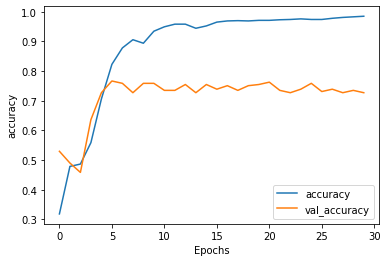

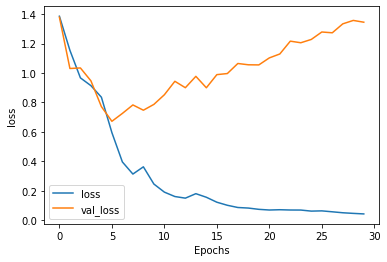

In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [43]:
from tensorflow.keras.models import load_model

lstm_model.save('models/lstm_model')  # creates a HDF5 file 'my_model.h5'
attention_lstm_model.save('models/attention_lstm_model')

del lstm_model  # deletes the existing model
del attention_lstm_model

# returns a compiled model
# identical to the previous one
lstm_model = load_model('models/lstm_model')
attention_lstm_model = load_model('models/attention_lstm_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/lstm_model/assets
INFO:tensorflow:Assets written to: models/attention_lstm_model/assets


In [44]:
lstm_model.summary()
attention_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               93600     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 804       
Total params: 254,404
Trainable params: 254,404
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(N

In [45]:
import pickle

# saving tokenizer
with open('models/tokenizer.pickle', 'wb') as tokenizerhandle:
    pickle.dump(tokenizer, tokenizerhandle, protocol=pickle.HIGHEST_PROTOCOL)
    tokenizerhandle.close()

# loading tokenizer
with open('models/tokenizer.pickle', 'rb') as tokenizerhandle:
    tokenizer = pickle.load(tokenizerhandle)
    tokenizerhandle.close()
    
# saving classes
with open('models/classes.pickle', 'wb') as classeshandle:
    pickle.dump(classes, classeshandle, protocol=pickle.HIGHEST_PROTOCOL)
    classeshandle.close()

# loading classes
with open('models/classes.pickle', 'rb') as classeshandle:
    classes = pickle.load(classeshandle)
    classeshandle.close()

In [46]:
import re
import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


def clean_data(transcription):
    lemmatizer = WordNetLemmatizer()
    message = re.sub('[^a-zA-Z]', ' ', str(transcription))
    message = message.lower()
    message = message.split()
    
    message = [lemmatizer.lemmatize(word) for word in message if not word in stopwords.words('english')]
    message = ' '.join(message)
    return message



In [47]:
transcription = tokenizer.texts_to_sequences([clean_data('type')])

In [48]:
transcription

[[302]]

In [49]:
transcription = pad_sequences(transcription, padding = 'post', truncating = 'post', maxlen = 120)

In [50]:
transcription

array([[302,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]], dtype=int32)

In [51]:
print(model.predict(transcription))

NameError: name 'model' is not defined

In [54]:
y_prob = model.predict(transcription) 
y_classes = y_prob.argmax(axis=-1)

In [55]:
y_classes[0]

3

In [56]:
classes[y_classes[0]]

' Surgery'

Data augmentation using nlpaug

In [60]:
import pandas as pd
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [92]:
df = pd.read_csv('transcription_samples.csv', usecols=['medical_specialty', 'transcription'])

In [93]:
df = df.dropna()

In [94]:
df.medical_specialty.value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Dentistry                          27
 Cosmetic / Plastic Surge

In [95]:
######### balancing dataset
def balance_dataset(df):
    df1 = df[df.medical_specialty == ' Consult - History and Phy.'].iloc[:355]
    df2 = df[df.medical_specialty == ' Cardiovascular / Pulmonary'].iloc[:355]
    df3 = df[df.medical_specialty == ' Orthopedic'].iloc[:355]
    df4 = df[df.medical_specialty == ' Surgery'].iloc[:355]
    
    frames = [df1, df2, df3, df4]
    return pd.concat(frames)

df = balance_dataset(df)

In [96]:
df.medical_specialty.value_counts()

 Orthopedic                    355
 Surgery                       355
 Cardiovascular / Pulmonary    355
 Consult - History and Phy.    355
Name: medical_specialty, dtype: int64

In [97]:
df = df.reset_index(drop=True)

In [98]:
def augment(df):
    aug_syn = naw.SynonymAug(aug_src='wordnet')
    # augmented_text = aug_syn.augment(text)
    augmented_texts = []
    labels = []
    for i in range(df.shape[0]):
        text = df.transcription[i]
        label = df.medical_specialty[i]
        for j in range(10):
            augmented_text = aug_syn.augment(text)
            augmented_texts.append(augmented_text)
            labels.append(label)

    data = {'transcription': augmented_texts, 'medical_specialty': labels}
    df = pd.DataFrame(data)
    return df

df = augment(df)

In [99]:
df.medical_specialty.value_counts()

 Orthopedic                    3550
 Surgery                       3550
 Consult - History and Phy.    3550
 Cardiovascular / Pulmonary    3550
Name: medical_specialty, dtype: int64

 Consult - History and Phy.    3550
 Cardiovascular / Pulmonary    3550
Name: medical_specialty, dtype: int64

In [35]:
bilstm_prediction = model.predict_classes(validation_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [36]:
bilstm_prediction

array([2, 0, 1, 2, 0, 1, 2, 3, 0, 1, 1, 2, 0, 0, 3, 1, 3, 0, 1, 0, 3, 3,
       1, 3, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3,
       1, 1, 3, 0, 3, 1, 0, 2, 3, 0, 0, 0, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1,
       3, 1, 3, 3, 0, 0, 3, 1, 0, 3, 3, 0, 0, 3, 0, 1, 1, 1, 3, 1, 1, 2,
       3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 2, 3, 3, 1, 2, 2, 3, 3, 1, 3, 0, 0,
       0, 0, 0, 1, 2, 0, 3, 3, 2, 3, 3, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 2,
       3, 1, 3, 3, 0, 0, 2, 1, 1, 0, 1, 0, 3, 3, 3, 2, 0, 3, 2, 0, 3, 0,
       1, 1, 2, 3, 3, 0, 3, 3, 0, 0, 2, 3, 3, 0, 3, 0, 3, 3, 0, 1, 3, 0,
       0, 3, 3, 3, 0, 3, 0, 3, 2, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3,
       1, 0, 3, 0, 0, 1, 3, 0, 3, 2, 3, 1, 0, 2, 1, 1, 3, 0, 3, 3, 2, 0,
       2, 1, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 0, 2, 1, 0, 0, 3, 2, 3,
       3, 2, 2, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 3, 3, 1, 0, 1, 1])

In [37]:
np.argmax(model.predict(validation_padded), axis=-1)

array([2, 0, 1, 2, 0, 1, 2, 3, 0, 1, 1, 2, 0, 0, 3, 1, 3, 0, 1, 0, 3, 3,
       1, 3, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 3,
       1, 1, 3, 0, 3, 1, 0, 2, 3, 0, 0, 0, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1,
       3, 1, 3, 3, 0, 0, 3, 1, 0, 3, 3, 0, 0, 3, 0, 1, 1, 1, 3, 1, 1, 2,
       3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 2, 3, 3, 1, 2, 2, 3, 3, 1, 3, 0, 0,
       0, 0, 0, 1, 2, 0, 3, 3, 2, 3, 3, 0, 1, 0, 0, 2, 1, 1, 0, 0, 0, 2,
       3, 1, 3, 3, 0, 0, 2, 1, 1, 0, 1, 0, 3, 3, 3, 2, 0, 3, 2, 0, 3, 0,
       1, 1, 2, 3, 3, 0, 3, 3, 0, 0, 2, 3, 3, 0, 3, 0, 3, 3, 0, 1, 3, 0,
       0, 3, 3, 3, 0, 3, 0, 3, 2, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3,
       1, 0, 3, 0, 0, 1, 3, 0, 3, 2, 3, 1, 0, 2, 1, 1, 3, 0, 3, 3, 2, 0,
       2, 1, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 0, 2, 1, 0, 0, 3, 2, 3,
       3, 2, 2, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 3, 3, 1, 0, 1, 1])